In [23]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats



class strehlCalc:   
    
    ## All paths must be in a list!
    # ex) 
        #pathToData=[None]*N
        #pathToData[0]='path'
        
        
        #real
        
# ###### Current attributes:

# User inputs upon object creation:

# All data should be .fits files
#     pathToData:     Path where the image data of the closed loop PSFs are stored. Each .fits file should have one data cube of image frames.

#     pathToFlats:    path where the PSF response to a flat wavefront is stored.                      
#                     This is what the closed loop PSFs are compared to in the Strehl calculation

#     pathToDarks:    If you have a dark image, input the path.
#                     Can be a single frame (Hopefully a mean frame from multiple dark frames), 
#                     or a data cube of individual dark frames that will be averaged for you.
#                     If not, the background will be estimated from the image frame.

#     drkSubtractDiameter:     
#                     Diameter in pixels of the circular mask that masks out the PSF 
#                     for the dark subtraction that is estimated from the image frame. 
#                     * A common fix to a bad strehl measurement is decreasing the diameter size. 
#                     If none is given the diameter of the mask will be 1/3 the smallest dimension of the data frame . 

# Class generated attributes:

## Saturation check. Each index corresponds to the file opened in the list pathTo... with the same index.

### The saturated value for the Basler Cameras is 1023, and is a hard coded value. If your camera has a different saturation value change it in code. 

#     darkSat:        True: dark data is oversaturated. False: dark data is not saturated
#     imageSat:       True: there are one or more frames in that file that are oversaturated. False: no frames in that file are oversaturated.
#     perfSat:        True: there are one or more frames in that file that are oversaturated. False: no frames in that file are oversaturated. 


#     imagePeak:      The peak values of the PSF used in Strehl Calculation
#     perfPeak:       The peak values of the perfect PSF the closed loop PSFs will be compared to in the Strehl Calculation
#     imgFlux:        The sum of the flux values of the PSF used in the Strehl Calculation. The flux is summed over circles of increasing diameter. 
#     perfFlux:       The sum of the flux values of the perfect PSF the closed loop PSFs will be compared to in the Strehl Calculation. The flux is summed over circles of increasing diameter.
#     fluxDiameter:   The diameters in pixels that the flux was summed over.

#     imageSize:      Size of the data cube containing the closed loop PSF data
#     perfSize:       Sixe of the data cube containing the images of the flat wavefront response PSF data

#     self.Strehl:    The calculated Strehl ratio for each image file, at each 

        
        
        
##### NOTE TO SELF MAKE A FUNCTION THAT LISTS ATTRIBUTES
    
    def __init__(self, pathToData,pathToFlats, pathToDarks=None,FWHM=None, smartPeak=None,drkSubtractDiameter=None):
        self.pathToData=pathToData
        self.pathToFlats=pathToFlats
        if pathToDarks:
            self.pathToDarks=pathToDarks
            self.darkSat, self.darkData, self.darkSize=self.openFile(self.pathToDarks)
        else:
            pathToDarks=None
        
        if FWHM:
            self.FWHM=FWHM
        #open the files, test if any are oversaturated  
        self.imageSat, imageData, self.imageSize=self.openFile(self.pathToData)
        self.perfSat, perfData, self.perfSize=self.openFile(self.pathToFlats)
            
        ## Check to make sure the data is not oversaturated and compatible with the pipeline. 
        #self.errorMsg()
        
        if smartPeak and FWHM==None:
            self.radialProfile, self.fullProfile=self.radialAverage(perfData)
            self.FWHM=self.fwhmEstimate()
        
        if smartPeak:
            xcentroid, ycentroid=self.smartPeakFinder(imageData)
            xPerfcentroid, yPerfcentroid=self.smartPeakFinder(perfData)
        
        if smartPeak==None:
            xcentroid, ycentroid=self.peakFinder(imageData)
            xPerfcentroid, yPerfcentroid=self.perkFinder(perfData)

        
#         # dark subtract + pull out image peak
#             xcentroid, ycentroid, self.pData, =self.darkSubtract(imageData)
#             xPerfcentroid, yPerfcentroid, self.pPerfData=self.darkSubtract(perfData)
        

#         else:
#             self.perfPeak=self.peakFinder(self.pPerfData)
#             self.imagePeak=self.peakFinder(self.pData)
        
# #       #Sum the Flux in a circle centered on the PSF at increasing radii.  
        
#         self.fluxDiameters, self.imageFlux=self.sumFlux(xcentroid, ycentroid,self.pData)
#         self.perfFluxDiameter, self.perfFlux=self.sumFlux(xPerfcentroid, yPerfcentroid, self.pPerfData)
        
# #         # Calculate the Strehl value. 
#         self.Strehl=self.strehlCalculator()
        
    
    
##### Functions -------------------------------------------------------------
        
                      
    def openFile(self, path):
            
        #check if it is a single file or multiple
        fileSize=np.shape(path)
        
        ## Pull a test file
        testFile=fits.open(path[0])
        testData=testFile[0].data
        dataSize=np.shape(testData)
        
        data=np.zeros((*fileSize,*dataSize))
        oversaturated=fileSize[0]*[None]
        
        data[0,:]=testData
        oversaturated[0]=np.any(testData == 1023)
        
        # Pull out the rest of the data and check if it is oversaturated
        for i in range(fileSize[0]-1):
            i=i+1
            testFile=fits.open(path[i])
            data[i,:]=testFile[0].data
            oversaturated[i]=np.any(data[i,:] == 1023)
        
        imageSize=np.shape(data)

            
        return oversaturated, data, imageSize
                           
    
    def darkSubtract(self, data, drkSubtractDiameter=None):
        
        imageSize=np.shape(data)
        
        #takes the mean if it is a data cube
        if hasattr(self, 'darkData'):
            dkData=np.mean(self.darkData,axis=0)
            for i in range(imageSize[0]):
                data[i,:]=np.subtract(data[i,:],dkData)
            print("Subtracted Dark Frame")

        
        ## Find peak of data to center mask: Assumes the max value in image is the peak.

        xcentroid=np.zeros((imageSize[0],imageSize[1]))
        ycentroid=np.zeros((imageSize[0],imageSize[1]))
        
        for i in range(imageSize[0]):
            for j in range(imageSize[1]):
                    max_xy=np.where(data[i,j,:,:]==data[i,j,:,:].max())
                    xcentroid[i,j]=max_xy[1][0]
                    ycentroid[i,j]=max_xy[0][0]
        
                
        ### Second round of background subtraction based of the image background.
        
        # Places a circle mask over the PSF data of diameter given by user input. 
        #If no user input, it uses a diameter=1/3 smallest dimension of a single data frame. 
        #After, row by row takes the mean value of the row, and subtracts it from that row. 
        
            
#         if drkSubtractDiameter == None:
#             check=min(imageSize[2],imageSize[3])
#             drkSubtractDiameter=np.round(check/3)
            
        drkSubtractDiameter=75
        
        pData=np.zeros(imageSize)
        
        for i in range(imageSize[0]):
            for j in range(imageSize[1]):
                mask=self.circle(imageSize[2],imageSize[3],drkSubtractDiameter,xcentroid[i,j],ycentroid[i,j])
                mask=1-mask
                dummy=mask*data[i,j,:]
                for k in range(imageSize[2]):
                    m=np.mean(dummy[k,:])
                    pData[i,j,k,:]=np.subtract(data[i,j,k,:],m)
                    

            
        return xcentroid, ycentroid, pData
    
    
    def peakFinder(self,data):
    #Stupid Peak finder. Pulls out the max value of the image as the peak. 
    ## Pull out the values of the PSF peak after dark subtraction
        imageSize=np.shape(data)
        peak=np.zeros((imageSize[0],imageSize[1]))
        for i in range(imageSize[0]):
            for j in range(imageSize[1]):
        #rPeak[i,j]=pData[i,j,int(ycentroid[i,j]),int(xcentroid[i,j])]
                peak[i,j]=np.max(data[i,j,:])
            
            return peak
        
        
    def smartPeakFinder(self,data):
        #Smart Peak finder using photutils from the astropy package
        
        if hasattr(self, 'FWHM')== False:
            fwhmEstimate()
            
            

        daofind = DAOStarFinder(fwhm=10, threshold=5.*sdev) 
        sz=np.shape(pData)
        peak=np.zeros(sz[0])
        xcentroid=np.zeros(sz[0])
        ycentroid=np.zeros(sz[0])
        for i in range(sz[0]):
            sources = daofind(pData[i,:,:]) 
        for col in sources.colnames: 
            sources[col].info.format = '%.8g'
        peak[i]=max((sources["peak"]))
        ind=np.where(sources["peak"]==max(sources["peak"]))
        xc=(sources["xcentroid"][ind[0]])
        yc=(sources["ycentroid"][ind[0]])     
        xcentroid[i]=int(np.round(xc[0]))
        ycentroid[i]=int(np.round(yc[0]))


    def fwhmEstimate(self):
        from astropy.modeling import models, fitting 
        s=np.round(len(self.fullProfile)/2)
        x=np.arange(-s+1,s,1)
        
        sz=np.shape(self.fullProfile)
        FWHM=zeros(sz[0])
        
        #fit Guassian to data
        for i in range(sz[0]):
            g_init = models.Gaussian1D(amplitude=1., mean=0, stddev=1)
            fit_g = fitting.LevMarLSQFitter()
            g = fit_g(g_init, x, self.fullProfile[i])
            FWHM[i]=2*np.sqrt(2*np.log(2))*g.stddev.value
            
        return FWHM
            
            


        
        
    
    def radialAverage(self,data):
        
        #calculates an estimated radial average in one frame of data per file. 
        #This is meant to be passed to the Full width half max estimator.
        
        imageSize=np.shape(data)
        check=min(imageSize[2],imageSize[3])
        #x=np.floor(np.floor(((np.floor((check/10))*10)/4))/10)*10
        x=np.floor(check/10)
        profileRange=range(2,80)
        xcentroid=np.zeros((imageSize[0]))
        ycentroid=np.zeros((imageSize[0]))
        radialA=np.zeros((imageSize[0],len(profileRange)))
        fullProfile=np.zeros((imageSize[0],2*len(profileRange)-1))
                          
        mask=np.zeros((imageSize[0],len(profileRange), imageSize[2],imageSize[3]))
        
        for i in range(imageSize[0]):
            max_xy=np.where(data[i,0,:]==data[i,0,:].max())
            xcentroid[i]=max_xy[1][0]
            ycentroid[i]=max_xy[0][0]
            
        count=0
        for i in range(imageSize[0]):
            for j in profileRange:
                m=self.circle(imageSize[2],imageSize[3],j,xcentroid[i],ycentroid[i])
                mask[i,j,:]=1-m
                if count>0:
                    tMask=mask[i,j,:]-mask[i,j-1,:]
                    dummy=tMask*data[i,0,:]
                    r=np.mean(dummy)
                    radialA[i,j,:]=r
                    count=count+1
                           
        for i in range(imageSize[0]):                  
            rFlip=np.flip(radialA)
            fullProfile[i,:]=np.concatenate((rFlix,radialA[1:]))
            ## uses the tail of the radial profile to estimate the DC term the data is shifted up from 0 from and subtract it off.
            m=np.mean(fullProfile[i,0:10])
            fullProfile[i,:]=fullProfile[i,0:10]-m
        
        
        return radialA, fullProfile
        
                           
                
       

            
        
    
    def sumFlux(self, xcentroid, ycentroid, data):
        
        
        imageSize=np.shape(data)
        check=min(imageSize[2],imageSize[3])
        #x=np.floor(np.floor(((np.floor((check/10))*10)/))/10)*10
        x=np.floor(check/10)
        r1=range(20, int(x), 10)
        sz2=np.shape(r1)
        rFlux=np.zeros((imageSize[0],imageSize[1],sz2[0]))
        for j in range(imageSize[0]):
            count=0
            for r in range(20,int(x),10):
                for i in range(imageSize[1]):
                    mask=self.circle(imageSize[2],imageSize[3], r, xcentroid[j,i], ycentroid[j,i])
                    mData=data[j,int(i),:,:]*mask
                    rFlux[j,int(i),count]=np.sum(mData)
                count=count+1 
        
        return r1, rFlux   
        
    def strehlCalculator(self):   
        #if only one data cube is given use it for all frames
        #if the same number of data cubes are given match the PSFs to the same index as the corresponding Flat
        
        # if there is a corresponding flat wavefront PSF data cube to each of the closed loop PSF data cubes
        
        if self.perfSize[0]>1:
            print("I am running A")
            sz=np.shape(self.imageFlux)
            Strehl=np.zeros((sz[0],sz[2]))
            for i in range(sz[0]): 
                for j in range(sz[2]):  
                    d[i,j]=np.mean(self.imagePeak[i,:]/self.imageFlux[i,:,j])
                    p[i,j]=np.mean((self.perfPeak[i,:]/self.perfFlux[i,:,j]))
                    Strehl[i,j]=d[i,j]/p[i,j]
                    
        
        # if there is a single flat wavefront PSF data cube corresponding to all of the closed loop PSF data cubes
        if self.perfSize[0]==1:
            print("I am running B")
            sz=np.shape(self.imageFlux)
            Strehl=np.zeros((sz[0],sz[2]))

            for i in range(sz[0]): 
                for j in range(sz[2]):  
                    d=np.mean(self.imagePeak[i,:]/self.imageFlux[i,:,j])
                    p=np.mean(self.perfPeak[0,:]/self.perfFlux[0,:,j])
                    Strehl[i,j]=d/p
        
        return Strehl
        
    def circle(self,s,v,d,x,y):
        s=s+1
        v=v+1
        cen=np.array([x,y])
        r=np.zeros([s,v])
        a=np.arange(-cen[0]+1,v-cen[0],1)
        b=np.arange(-cen[1]+1,s-cen[1],1)
        [X,Y]=np.meshgrid(a,b)
        r=np.sqrt(np.double((X**2+Y**2)))
        c = (r<=d/2).astype(int)
        return c
        
        
    def errorMsg(self):
        
        if self.perfSize[0]>1 and self.perfSize[0] != self.imageSize[0]:
            print("Error: The flat wavefront PSF data frames must be either a single data cube, or a number of data cubes equalling the number of closed loop PSF data cubes.")
            raise ValueError
        if self.imageSat == True:
            print("One or more of the closed loop PSF data frames is oversaturated.")
            raise ValueError
        if self.perfSat == True:
            print("One or more of the flat wavefront PSF data frames is oversaturated.")
            raise ValueError
        if self.darkSat == True:
            print("One of more of the dark frames is oversaturated.")
            raise ValueError
        
        
    
    
        
        
            

In [19]:
pathToData=[None]
pathToFlats=[None]
pathToDarks=[None]

pathToFlats[0]='/Users/laurenschatz/Documents/exao0Pull/CACTIfigs/camtipFlat.fits'
pathToData[0]='/Users/laurenschatz/Documents/exao0Pull/CACTIfigs/camtipFlat.fits'




In [24]:
a=strehlCalc(pathToData,pathToFlats, smartPeak=True)

IndexError: tuple index out of range

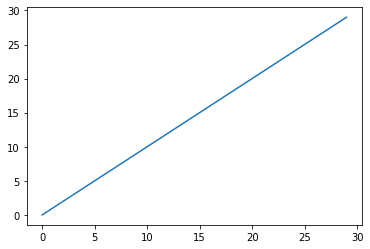

In [13]:
r1=range(0, int(30), 1)
plt.plot(r1)

In [23]:
print(range(2,80))
a=range(2,80)
print(len(a))

range(2, 80)
78


In [29]:
check=min(356,356)

x=np.floor(np.floor(((np.floor((check/10))*10)/4))/10)*10
print(x)

80.0


In [37]:
x=np.zeros(40)
y=np.concatenate((x,x[1:]))
print(np.shape(y))

(79,)


In [43]:
s=np.round(len(y)/2)
print(s)
x=np.arange(-s+1,s,1)
print(x)

40.0
[-39. -38. -37. -36. -35. -34. -33. -32. -31. -30. -29. -28. -27. -26.
 -25. -24. -23. -22. -21. -20. -19. -18. -17. -16. -15. -14. -13. -12.
 -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.
   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.
  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.
  31.  32.  33.  34.  35.  36.  37.  38.  39.]
